<img src='Static_figs/LSASAF_NoName_Colour.png' align='right' width='25%'></img>

<div class="alert alert-block alert-success">
<b>PREREQUISITE </b><br>
    
For smooth experience some actions are needed:
* It is expected for user to be familiar with Python.

# Calculation of Fractional Vegetation Cover anomaly (FVC) based on LSA SAF ETFVC product using data access via the THREDDS server

#### About
The [LSA-SAF Fraction of Vegetation Cover (ETFVC)](https://landsaf.ipma.pt/en/data/products/vegetation/) is a 10-day Fraction of Vegetation Cover (FVC) retrieval from clear-sky observations performed by AVHRR/Metop. FVC defines an important structural property of a plant canopy, which corresponds to the complement to the unity of the gap fraction at the nadir direction, accounting for the amount of vegetation distributed in a horizontal perspective. It is relevant for a wide range of Land Biosphere Applications such as agriculture and forestry, environmental management, and land use.

In this notebook, we calculate FVC anomaly compared to a few years reference period (2015-2021). The intensity of anomalies can serve as an indicator of various abnormal situations within the ecosystem, in this case, drought in 2022. Demonstration of the analysis is conducted at selected locations characterized by well-known vegetative ground layers. For each location, the corresponding ETFVC pixel value is used for calculating the anomaly.

OPeNDAP protocol to access the THREDDS server is one of the options to access the LSA SAF products, that are available in `NetCDF4` format. The main advantage is the ability to access only a subset of the `NetCDF4` file and thus save memory. Furthermore, data can be stored directly in RAM instead of preloading all `NetCDF4` files into the hard-drive. OPeNDAP is supported by `xarray` Python library.

#### How to access the data

Data can be accessed from [LSA-SAF data server](https://datalsasaf.lsasvcs.ipma.pt/PRODUCTS/EPS/ETFVC/), prior registration is needed.

#### Basic facts on the LSA SAF ETFVC
 > **Product number**: LSA-403
 >
 > **Spatial resolution**: 1km at Nadir 
 >
 > **Spatial coverage**: Full Globe
 >
 > **Time steps**: 10 day  
 >
 > **Data availability**: From 2015

#### Module Outline:
* [1 - Accessing the Data](#First)
* [2 - Calculating the FVC Anomaly](#Second)
* [3 - Plotting](#Third)

### <a id='First'></a>1. Accessing the Data

We start by importing all the necessary libraries:

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
import datetime as dt
import xarray as xr
import numpy as np 
import pandas as pd
from tqdm import tqdm

In the next step, we set the locations of interest for which we intend to calculate the FVC anomaly. Locations are presented as a `pandas.Dataframe` with columns name, latitude, longitude and surface type. Such an approach was adapted, since `pandas.Dataframe`object can be easily imported from `.csv`or similar file in case the user, wishes to calculate FVC anomaly for a custom location.

Locations, that we don't want to plot are commented. They can be un-commented if they are desired to be shown on the final plot.

In [2]:
# Dataframe containing locations and descriptions is constructed
locations_df =pd.DataFrame(
                        [["SI, Bilje", 45.90333, 13.64980, "Vineyards" ],
                        ["IT, Ferrara", 44.90420, 11.28128, "Fields" ],
                        ["PT, Evora", 38.540, -8.003, "Deciduous forest"], 
                        ["SI, Trnovksi gozd", 46.00, 13.80, "Mixed beech-fir forest"],
                        #["SI, Pokljuka", 46.35, 13.95, "Spruce forest"],
                        #["DR Kongo", -1.40, 21.45, "Tropical forest"],
                        #["SI, Krakovski gozd", 45.88691, 15.40765, "Deciduous forest"],
                        ],
                        columns=["Name", "lat", "lon", "Type"]
                        )

# Check the dataframe
print(locations_df)

                Name       lat       lon                    Type
0          SI, Bilje  45.90333  13.64980               Vineyards
1        IT, Ferrara  44.90420  11.28128                  Fields
2          PT, Evora  38.54000  -8.00300        Deciduous forest
3  SI, Trnovksi gozd  46.00000  13.80000  Mixed beech-fir forest


The data will be accessed by the virtue of [OpenDAP protocol](https://gitlab.com/helpdesk.landsaf/lsasaf_data_access/-/wikis/data/thredds) from [LSA SAF THREEDS server](https://thredds.lsasvcs.ipma.pt/). OpenDAB protocol is currently in the demonstrational phase. It allows the user to only load a subset of `NetCDF4` file, for instance only a 2D (lat-lon) slice or a list of points.

This is of significant importance when dealing with European Polar Service (EPS) products in comparison with Meteosat Second Generation (MSG) products since EPS product NetCDF4 files consist of approximately 10 times more data points than MSG files. In the case of the ETFVC product, we are dealing with NetCDF files with approximately 250 MB each, which can require a significant amount of available memory, when calculating the climatology.

`OpenDAB` protocol on the other hand allows us to load (or save) only a subset of interest, which allows the processing of bigger files on PC rather than requiring HPC with sufficient memory and processor power. In order to access the data, one needs to [register](https://gitlab.com/helpdesk.landsaf/lsasaf_data_access/-/wikis/credentials/register). The examples on how to access the THREEDS server are available [here](https://gitlab.com/helpdesk.landsaf/lsasaf_data_access/-/wikis/data/thredds), while the documentation is available [here](https://www.unidata.ucar.edu/software/tds/). A catalog of available data is accessible with a prior registration [here](https://thredds.lsasvcs.ipma.pt/thredds/catalog/catalog.html).

In general, one can use `xarray.open_dataset()` to access the THREDDS data. The location of the dataset needs to be specified as follows: `https://<USERNAME>:<PASSWORD>@thredds.lsasvcs.ipma.pt/thredds/dodsC/<satellite>/<product>/<format>/<year>/<month>/<day>/filename`.

An example of accessing the ETFVC product from 25 August 2015 will be made. We start by saving the username and password:

In [3]:
USER="***"
PASSWD="***"

Then we define our `xarray.DataSet`. The `xarray`library uses lazy load, therefore the data will be loaded, when we use `DataSet.load()` or call the data in the dataset.

In [4]:
test_ds=xr.open_dataset("https://"
            +USER
            +":"
            +PASSWD
            +"@thredds.lsasvcs.ipma.pt/thredds/dodsC/EPS/ETFVC/NETCDF/2015/08/25/NETCDF4_LSASAF_M01-AVHR_ETFVC_GLOBE_201508250000.nc")
print(test_ds)

<xarray.Dataset>
Dimensions:         (lat: 18001, lon: 36000, time: 1)
Coordinates:
  * lat             (lat) float32 -90.0 -89.99 -89.98 ... 89.98 89.99 90.0
  * lon             (lon) float32 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time            (time) datetime64[ns] 2015-08-25
Data variables:
    crs             |S64 ...
    FVC             (time, lat, lon) float32 ...
    Z_Age           (time, lat, lon) float32 ...
    quality_flag    (time, lat, lon) float32 ...
    standard_error  (time, lat, lon) float32 ...
Attributes: (12/29)
    references:                      Data provided by the EUMETSAT Satellite ...
    easternmost_longitude:           -180.0
    westernmost_longitude:           179.989990234375
    spatial_resolution:               0.01x 0.01
    geospatial_lat_units:            degrees_north
    geospatial_lon_units:            degrees_east
    ...                              ...
    geospatial_lat_resolution:        0.01
    geospatial_lon_resolution:       

Now we can load only a slice of total data (available for latitudes from 0°to 90° N and S and longitudes from 0° to 180˚ E and W). We chose the rectangle with longitudes between 10˚ W and 30° E and latitudes between 30° N and 70° N.

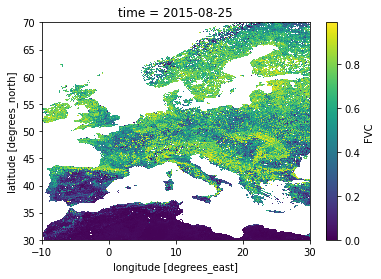

In [5]:
# Slice a desired part of NetCDF4 file
test_ds=test_ds.sel(lat=slice(30,70), lon=slice(-10, 30))

# Plot the slice
test_ds.FVC.plot()

# Close dataset to save the memory
test_ds.close()

### <a id='Second'></a>2. Calculating the FVC Anomaly

In order to calculate FVC anomaly for the desired locations we first need to calculate climatology. We calculate average FVC values for the same day and location over a set number of years. In the next cell, we will specify a range of dates, for which we want to calculate the anomaly and a range of years, which will be used to calculate climatology.

Since EPS products are only available 3 times per month (1st, 5th and 25th of each month) we first construct a list of dates for the whole year and then filter out the unwanted dates.

In [6]:
# We can set start and end date using the following 2 variables:
start_date=dt.datetime(2022, 1, 1, 0, 0, 0)
end_date=dt.datetime(2022, 12, 31, 0, 0, 0)

# A list of days of interest is generated.
date_range=pd.date_range(start_date,end_date,freq='1d')

# Filter the daterange to only 5, 15, 25
date_range = date_range[(date_range.day == 5) | (date_range.day == 15) | (date_range.day == 25)]

#Define start and end of climatology
climatology_start=dt.datetime(2015,1,1)
climatology_end=dt.datetime(2021, 12, 31)

# Define a range of years for climatology
climatology_reference_years=pd.date_range(climatology_start, climatology_end, freq='1Y')

# Define empty arrays for results
product_values=np.full((locations_df.shape[0], len(date_range)), np.nan)
climatology_values=np.full((locations_df.shape[0], len(date_range)), np.nan)

To simplify our work we make a function, that calculates the value of the desired LSA SAF product. The same function can be used, to access LSA SAF products ETFVC, ETFAPAR and ETLAI (all related to the vegetation) via the THREDDS server. The function takes a list of latitudes and longitudes of points of interest. It then returns the list of product values for each point.

The function input is the list of latitudes and a list of longitudes of points of interest. Detailed instructions on how to index the data within `xarray` can be found [here](https://docs.xarray.dev/en/stable/user-guide/indexing.html).

In [7]:
def get_data(date, product, lat_input, lon_input):
    '''
    Loads vegetation product into a dataset and returns value for one particular location
    product = string ("LAI", "FAPAR", "FVC")
    date = pd.datetime
    lat, lon = list of floats
    '''

    target_lat = xr.DataArray(lat_input, dims="points")
    target_lon = xr.DataArray(lon_input, dims="points")


    LSA_SAF_ds=xr.open_dataset("https://"
                                +USER+":"
                                +PASSWD
                                +"@thredds.lsasvcs.ipma.pt/thredds/dodsC/EPS/ET"
                                +product
                                +"/NETCDF/"
                                +str("{:02d}".format(date.year))+"/"
                                +str("{:02d}".format(date.month))+"/"
                                +str("{:02d}".format(date.day))+"/"
                                +"NETCDF4_LSASAF_M01-AVHR_ET"
                                +product
                                +"_GLOBE_"
                                +str("{:02d}".format(date.year))
                                +str("{:02d}".format(date.month))
                                +str("{:02d}".format(date.day))
                                +"0000.nc", decode_times=False)


    LSA_SAF_value=LSA_SAF_ds.sel(lat=target_lat, lon=target_lon, method="nearest")[product].load().values[0]
    
    LSA_SAF_ds.close()

    return LSA_SAF_value

We can test our function to access and plot FVC for the desired dates and locations and then save the results. Since we are directly accessing the data over the internet the control of potential errors is advised. In this example, the missing files are not printed, but this can be changed by setting the `ERROR_OUTPUT` to `True`.

In [8]:
ERROR_OUTPUT=False

In [9]:
# Loop over datetime objects
for i, date in tqdm(enumerate(date_range)):

        #for j in range(locations_df.shape[0]): 
    try:                      
            product_values[:, i]=get_data(date, "FVC", locations_df["lat"], locations_df["lon"])
    
    except Exception as e:
           if ERROR_OUTPUT:
                print(e)
                print("Missing date"+str(date_range[i]))

36it [01:54,  3.18s/it]


We can now check the resulting FVC estimations:

Text(0.5, 1.0, 'Fractional Vegetation Cover (FVC) \n Range: [0, 1]')

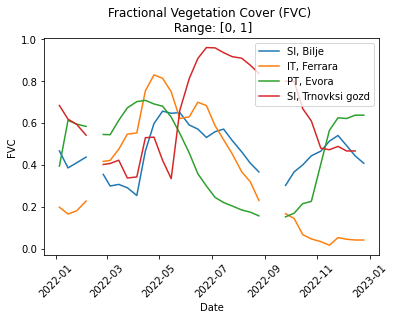

In [10]:
for j in range(locations_df.shape[0]):
    plt.plot(date_range.to_list(), product_values[j,:], label=locations_df["Name"].iloc[j])

plt.legend()
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("FVC")
plt.title("Fractional Vegetation Cover (FVC) \n Range: [0, 1]")

We can define a function, that calculates climatology for the desired day. It accesses the FVC value for the same day in all years specified in the global variable `climatology_reference_years` and then returns an average.

In [11]:
def calculate_climatology(date, product, lat_input, lon_input):
    '''
    Calculates the reference (climatology) of a LSA SAF vegetation product
    product = string ("LAI", "FAPAR", "FVC")
    date = pd.datetime
    lat, lon = list of floats   
    '''
    reference_values=np.full((len(climatology_reference_years), locations_df.shape[0]), np.nan)

    for i in range(len(climatology_reference_years)):
        try:
            reference_values[i,:]=get_data(date.replace(climatology_reference_years[i].year), product, lat_input, lon_input)
        
        except Exception as e:
            if ERROR_OUTPUT:
                print(e)
                #print("Missing date: "+str(date.replace(climatology_reference_years[i].year)))
    
    return np.nanmean(reference_values, axis=0)

We can now calculate and plot climatology:

In [12]:
# Loop over datetime objects
for i, date in tqdm(enumerate(date_range)):


        try:                      
                climatology_values[:, i]=calculate_climatology(date, "FVC", locations_df["lat"], locations_df["lon"])
        except Exception as e:
               print(e)

36it [11:44, 19.58s/it]


Text(0.5, 1.0, 'Fractional Vegetation Cover (FVC) climatology \n Range: [0, 1]')

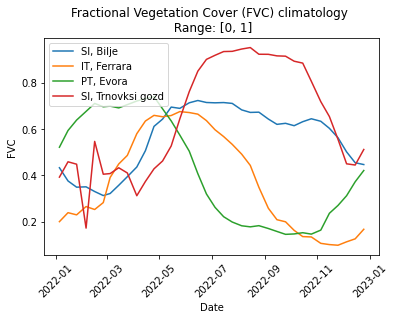

In [13]:
for j in range(locations_df.shape[0]):
    plt.plot(date_range.to_list(), climatology_values[j,:], label=locations_df["Name"].iloc[j])

plt.legend()
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("FVC")
plt.title("Fractional Vegetation Cover (FVC) climatology \n Range: [0, 1]")

### <a id='Third'></a>3. Plotting

It is desired to prepare a meaningful representation of the collected data. We decided to present the FVC for the year 2022, for 3 locations in the Mediterranean, where drought occurred in 2022. It was assumed, that the drought would be visible as a smaller FVC than the average (climatology).

For a nicer presentation, we first defined a list of well-distinct colors. Furthermore, It was decided, to calculate a 3-point rolling average of the FVC anomaly, to make a plot more clear. Therefore a function, that calculates the rolling average was defined.

In [14]:
def rolling_average(arr, window):
    weights = np.ones(window) / window
    result = np.convolve(arr, weights, mode='valid')
    
    # Pad with NaN values to maintain the original length
    padding = np.full(len(arr) - len(result), np.nan)
    result = np.concatenate((padding, result))

    return result

In the next cell, we plot FVC together with the corresponding climatology for the locations of interest. A for loop is used, so the number of plots can automatically adapt to the number of locations defined at the beginning of this notebook.

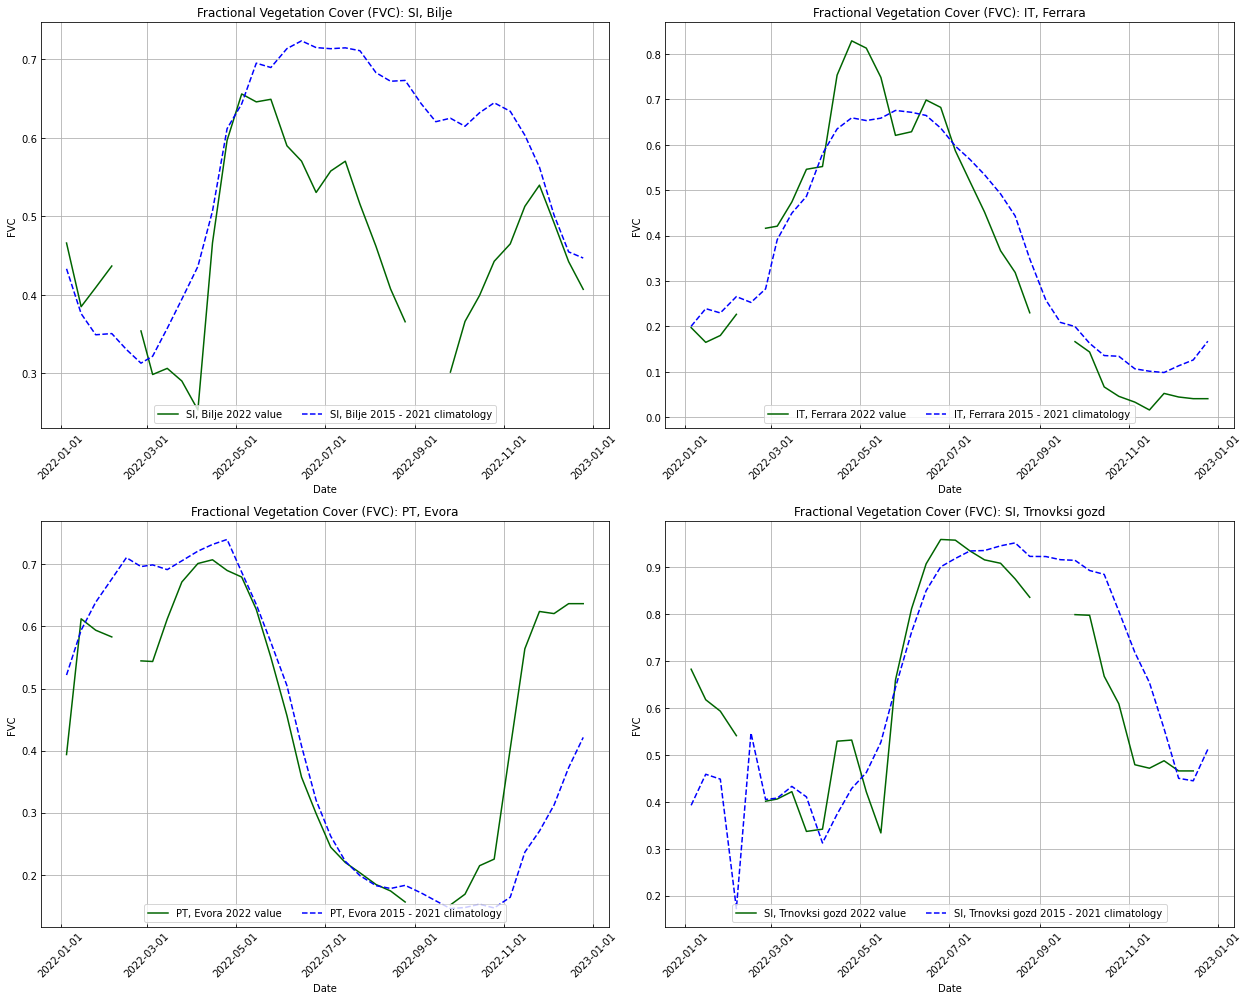

In [15]:
# Define figure and subplots
fig, ax = plt.subplots((locations_df.shape[0]+1)//2, 2, figsize=(17.5, 14))

# Flaten ax array, to simplify iteration
ax=ax.flatten()

# for loop over all locations:
for j in range(locations_df.shape[0]):
    
    # Plot data
    ax[j].plot(date_range.to_list(), product_values[j,:],
               label=locations_df["Name"].iloc[j]+" {} value".format(start_date.year),
               color="darkgreen",
               linestyle="solid")

    # Plot climatology
    ax[j].plot(date_range.to_list(), climatology_values[j,:],
               label=locations_df["Name"].iloc[j]+" {} - {} climatology".format(climatology_start.year, climatology_end.year),
               color="blue",
               linestyle="dashed")
    
    # Customize plot (major formatter must be used together with major locator)
    ax[j].tick_params(axis='both', direction='in')
    ticks = ax[j].get_xticks()
    ax[j].xaxis.set_major_locator(FixedLocator(ticks))
    ax[j].set_xticklabels(ticks, rotation=45)
    ax[j].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))


    ax[j].legend(ncol=2, loc="lower center")

    ax[j].set_title("Fractional Vegetation Cover (FVC): "+locations_df["Name"].iloc[j])
    ax[j].grid()
    ax[j].set_xlabel("Date")
    ax[j].set_ylabel("FVC")

plt.tight_layout()

A significant deviation from the reference (climatology) can be observed in Bilje, Slovenia, whish is consistent with drought in SW Slovenia in 2022, which caused approximately [150 milions EUR of damage in agriculture](https://www.sveti-jurij.si/DownloadFile?id=573325).

### References:

* array Developers (2023). xarray User Guide. [https://docs.xarray.dev/en/stable/user-guide/index.html](https://docs.xarray.dev/en/stable/user-guide/index.html). Accesed: 20.11.2023.